In [ ]:
import os
import sys
import math
import datetime

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras import mixed_precision
from keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import (
    Add, 
    Input, 
    Dense, 
    Conv2D, 
    Lambda, 
    Reshape, 
    Multiply, 
    Activation, 
    Concatenate, 
    SeparableConv2D, 
    GlobalAveragePooling2D, 
    GlobalMaxPooling2D
)

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))
from SRModels.metrics import psnr, ssim
from SRModels.loading_methods import load_dataset_as_patches
from SRModels.data_augmentation import AdvancedAugmentGenerator
from SRModels.constants import EDSR_PATCH_SIZE, EDSR_STRIDE, RANDOM_SEED, EDSR_SCALE_FACTOR

mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Ti, compute capability 8.6


In [2]:
class CosineAnnealingWithRestarts(Callback):
    def __init__(self, T_max, eta_max, eta_min=0, T_mult=2):
        super().__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.T_mult = T_mult
        self.epochs_since_restart = 0
        self.next_restart = T_max
        self.lr = eta_max

    def on_epoch_begin(self, epoch, logs=None):
        if epoch == 0:
            self.lr = self.eta_max
        elif epoch == self.next_restart:
            self.epochs_since_restart = 0
            self.next_restart += self.T_max * self.T_mult
            self.T_max *= self.T_mult
            self.lr = self.eta_max
        else:
            self.epochs_since_restart += 1
            cos_inner = (math.pi * self.epochs_since_restart) / self.T_max
            self.lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(cos_inner)) / 2
            
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)
    
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['CosineAnnealingWithRestarts_lr'] = self.lr

class CyclicLR(Callback):
    def __init__(self, base_lr=1e-5, max_lr=1e-3, step_size=2000, mode='triangular'):
        super().__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.iterations = 0
        self.lr = base_lr

    def clr(self):
        cycle = math.floor(1 + self.iterations / (2 * self.step_size))
        x = abs(self.iterations / self.step_size - 2 * cycle + 1)
        scale = max(0, (1 - x))
        
        if self.mode == 'triangular':
            return self.base_lr + (self.max_lr - self.base_lr) * scale
        elif self.mode == 'triangular2':
            return self.base_lr + (self.max_lr - self.base_lr) * scale / (2 ** (cycle - 1))
        elif self.mode == 'exp_range':
            gamma = 0.99994
            return self.base_lr + (self.max_lr - self.base_lr) * scale * (gamma ** self.iterations)
        else:
            raise ValueError("Unknown mode: %s" % self.mode)

    def on_train_batch_begin(self, batch, logs=None):
        self.iterations += 1
        self.lr = self.clr()
        
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['CyclicLR'] = self.lr

In [ ]:
class EDSR:
    def __init__(self):
        self.model = None
        self.scale_factor = None
        self.trained = False

    def setup_model(
            self, 
            scale_factor=2, 
            channels=3, 
            num_res_blocks=16, 
            num_filters=64, 
            res_scaling=0.1, 
            learning_rate=1e-4, 
            loss="mean_absolute_error", 
            from_pretrained=False, 
            pretrained_path=None):
        """Set up the EDSR model, either by loading a pretrained model or building a new one."""
        
        self.scale_factor = scale_factor
        
        if from_pretrained:
            if pretrained_path is None or not os.path.isfile(pretrained_path):
                raise FileNotFoundError(f"Pretrained model file not found at {pretrained_path}")
            
            self.model = load_model(pretrained_path, custom_objects={"psnr": psnr, "ssim": ssim})
            self.trained = True
            print(f"Loaded pretrained model from {pretrained_path}")
        else:
            self._build_model(scale_factor, channels, num_res_blocks, num_filters, res_scaling)
            self._compile_model(learning_rate, loss)
            
    def _channel_attention(self, x, reduction=16):
        """Channel Attention Module (Squeeze-and-Excitation style)."""
        
        channel = x.shape[-1]
        
        avg_pool = GlobalAveragePooling2D()(x)
        max_pool = GlobalMaxPooling2D()(x)
        
        shared_dense_one = Dense(channel // reduction, activation='relu', kernel_initializer='he_normal', use_bias=True)
        shared_dense_two = Dense(channel, activation='sigmoid', kernel_initializer='he_normal', use_bias=True)
        
        avg_out = shared_dense_one(avg_pool)
        avg_out = shared_dense_two(avg_out)
        
        max_out = shared_dense_one(max_pool)
        max_out = shared_dense_two(max_out)
        
        scale = Add()([avg_out, max_out])
        scale = Activation('sigmoid')(scale)
        scale = Reshape((1, 1, channel))(scale)
        
        return Multiply()([x, scale])

    def _spatial_attention(self, x):
        """Spatial Attention Module."""
        
        avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
        
        concat = Concatenate(axis=-1)([avg_pool, max_pool])
        
        sa = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid', kernel_initializer='he_normal')(concat)
        
        return Multiply()([x, sa])
    
    def _residual_block(self, x, num_filters, res_scaling, use_separable=False):
        """Build a residual block without batch normalization (key feature of EDSR)."""
        
        shortcut = x
        
        # First conv layer
        if use_separable:
            x = SeparableConv2D(num_filters, (3, 3), padding="same", kernel_initializer="he_normal")(x)
        else:
            x = Conv2D(num_filters, (3, 3), padding="same", kernel_initializer="he_normal")(x)
        x = Activation("relu")(x)
        
        # Second conv layer
        if use_separable:
            x = SeparableConv2D(num_filters, (3, 3), padding="same", kernel_initializer="he_normal")(x)
        else:
            x = Conv2D(num_filters, (3, 3), padding="same", kernel_initializer="he_normal")(x)
        
        # Channel Attention
        x = self._channel_attention(x)
        
        # Spatial Attention
        x = self._spatial_attention(x)
        
        # Scale the residual
        if res_scaling != 1.0:
            x = Lambda(lambda t: t * res_scaling)(x)
        
        # Add shortcut connection
        x = Add()([x, shortcut])
        
        return x

    def _upsampling_block(self, x, scale_factor, num_filters):
        """Create upsampling block using sub-pixel convolution."""
        
        if scale_factor == 2:
            x = Conv2D(num_filters * 4, (3, 3), padding="same", kernel_initializer="he_normal")(x)
            x = Lambda(lambda x: tf.nn.depth_to_space(x, 2))(x)
        elif scale_factor == 3:
            x = Conv2D(num_filters * 9, (3, 3), padding="same", kernel_initializer="he_normal")(x)
            x = Lambda(lambda x: tf.nn.depth_to_space(x, 3))(x)
        elif scale_factor == 4:
            # Two 2x upsampling blocks
            x = Conv2D(num_filters * 4, (3, 3), padding="same", kernel_initializer="he_normal")(x)
            x = Lambda(lambda x: tf.nn.depth_to_space(x, 2))(x)
            x = Conv2D(num_filters * 4, (3, 3), padding="same", kernel_initializer="he_normal")(x)
            x = Lambda(lambda x: tf.nn.depth_to_space(x, 2))(x)
        else:
            raise ValueError(f"Scale factor {scale_factor} not supported. Use 2, 3, or 4.")
        
        return x

    def _build_model(self, scale_factor, channels, num_res_blocks, num_filters, res_scaling):
        """Construct the EDSR model architecture using functional API."""
        
        inputs = Input(shape=(None, None, channels), name="input")
        
        # Initial convolution (head)
        x = Conv2D(num_filters, (3, 3), padding="same", kernel_initializer="he_normal")(inputs)
        
        # Store for global residual connection
        head_output = x
        
        # Residual blocks (body)
        for i in range(num_res_blocks):
            use_separable = (i % 2 == 0)
            x = self._residual_block(x, num_filters, res_scaling, use_separable)
        
        # Final convolution of the body
        x = Conv2D(num_filters, (3, 3), padding="same", kernel_initializer="he_normal")(x)
        
        # Global residual connection
        x = Add()([x, head_output])
        
        # Upsampling blocks (tail)
        x = self._upsampling_block(x, scale_factor, num_filters)
        
        # Final convolution to produce RGB output
        outputs = Conv2D(channels, (3, 3), padding="same", kernel_initializer="he_normal")(x)
        
        self.model = Model(inputs, outputs, name="EDSR")

    def _compile_model(self, learning_rate, loss):
        """Compile the model with Adam optimizer and specified loss, including PSNR and SSIM metrics."""
        
        optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
        self.model.compile(optimizer=optimizer, loss=loss, metrics=[psnr, ssim])
        self.model.summary()

    def fit(
            self, 
            X_train, 
            Y_train, 
            X_val, 
            Y_val, 
            batch_size=16, 
            epochs=300, 
            use_augmentation=True, 
            use_mix=True, 
            augment_validation=False):
        """Train the model using optional image data augmentation and standard callbacks."""
        
        if self.model is None:
            raise ValueError("Model is not built yet.")

        devices = tf.config.list_physical_devices("GPU")
        if devices:
            print("Training on GPU:", devices[0].name)
        else:
            print("Training on CPU")

        callbacks = [
            EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True), 
            ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-7, verbose=1), 
            CosineAnnealingWithRestarts(T_max=10, eta_max=1e-3, eta_min=1e-5, T_mult=2), 
            CyclicLR(base_lr=1e-5, max_lr=1e-3, step_size=2000, mode='triangular')
        ]

        if use_augmentation:
            train_gen = AdvancedAugmentGenerator(X_train, Y_train, batch_size=batch_size, shuffle=True, use_mix=use_mix)

            if augment_validation:
                # (Not recommended by default)
                val_gen = AdvancedAugmentGenerator(X_val, Y_val, batch_size=batch_size, shuffle=False, use_mix=use_mix)

                self.model.fit(
                    train_gen,
                    steps_per_epoch=len(train_gen),
                    epochs=epochs,
                    validation_data=val_gen,
                    validation_steps=len(val_gen),
                    callbacks=callbacks
                )
            else:
                self.model.fit(
                    train_gen,
                    steps_per_epoch=len(train_gen),
                    epochs=epochs,
                    validation_data=(X_val, Y_val),
                    callbacks=callbacks
                )
        else:
            self.model.fit(
                X_train, Y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(X_val, Y_val),
                callbacks=callbacks
            )

        self.trained = True

    def evaluate(self, X_test, Y_test):
        """Evaluate the model on test data and print loss, PSNR, and SSIM."""
        
        if not self.trained:
            raise RuntimeError("Model has not been trained.")

        results = self.model.evaluate(X_test, Y_test)
        print(f"Loss: {results[0]:.4f}, PSNR: {results[1]:.2f} dB, SSIM: {results[2]:.4f}")
        
        return results
    
    def super_resolve_image(self, lr_img_path, patch_size_lr=48, stride=24):
        """
        Super-resolves a single LR image from a file path using patch-wise prediction and reconstructs the HR image.
        
        Args:
            lr_img_path (str): Path to the input LR image.
            patch_size_lr (int): Size of LR patches.
            stride (int): Stride for patch extraction.
        
        Returns:
            np.ndarray: Super-resolved HR image, float32 in [0, 1].
        """
        
        if not self.trained:
            raise RuntimeError("Model has not been trained.")

        # --- Read and preprocess the LR image ---
        lr_img = cv2.imread(lr_img_path, cv2.IMREAD_COLOR)
        
        if lr_img is None:
            raise ValueError(f"Could not read image at {lr_img_path}")
        
        # Convert BGR (OpenCV default) to RGB and normalize to [0, 1]
        lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        # --- Calculate HR patch size based on scale factor ---
        patch_size_hr = patch_size_lr * self.scale_factor

        # --- Padding to ensure full coverage when extracting patches ---
        h, w, c = lr_img.shape
        
        pad_h = (patch_size_lr - (h % stride)) % stride if h % stride != 0 else 0
        pad_w = (patch_size_lr - (w % stride)) % stride if w % stride != 0 else 0
        
        pad_h = max(pad_h, patch_size_lr - stride)
        pad_w = max(pad_w, patch_size_lr - stride)
        
        lr_img_padded = np.pad(
            lr_img,
            ((0, pad_h), (0, pad_w), (0, 0)),
            mode='reflect'
        )
        
        padded_h, padded_w, _ = lr_img_padded.shape

        # --- Prepare output HR image and weight map for overlap-averaging ---
        hr_img_shape = (padded_h * self.scale_factor, padded_w * self.scale_factor, c)
        hr_img = np.zeros(hr_img_shape, dtype=np.float32)
        weight_map = np.zeros(hr_img_shape, dtype=np.float32)

        # --- Extract LR patches, predict HR patches, and reconstruct HR image ---
        for i in range(0, padded_h - patch_size_lr + 1, stride):
            for j in range(0, padded_w - patch_size_lr + 1, stride):
                # Extract LR patch
                lr_patch = lr_img_padded[i:i+patch_size_lr, j:j+patch_size_lr]
                # Add batch dimension for model prediction
                lr_patch_batch = np.expand_dims(lr_patch, axis=0)
                # Predict HR patch using the model
                sr_patch = self.model.predict(lr_patch_batch, verbose=0)[0]
                # Calculate the position in the HR image
                hr_i = i * self.scale_factor
                hr_j = j * self.scale_factor
                # Add predicted patch to the HR image
                hr_img[hr_i:hr_i+patch_size_hr, hr_j:hr_j+patch_size_hr] += sr_patch
                # Update weight map for overlap-averaging
                weight_map[hr_i:hr_i+patch_size_hr, hr_j:hr_j+patch_size_hr] += 1.0

        # --- Normalize by the weight map to average overlapping regions ---
        weight_map[weight_map == 0] = 1.0
        hr_img /= weight_map

        # --- Remove padding to return image with original upscaled size ---
        out_h = h * self.scale_factor
        out_w = w * self.scale_factor
        hr_img = hr_img[:out_h, :out_w]

        # --- Clip values to [0, 1] and return ---
        sr_img = np.clip(hr_img, 0.0, 1.0)
        
        return sr_img

    def save(self, directory="models/EDSR"):
        """Save the trained model with a timestamp in the specified directory."""
        
        if not self.trained:
            raise RuntimeError("Cannot save an untrained model.")

        os.makedirs(directory, exist_ok=True)
        
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        path = os.path.join(directory, f"EDSR_x{self.scale_factor}_{timestamp}.h5")
        
        self.model.save(path)
        
        print(f"Model saved to {path}")

In [4]:
HR_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../../data/images/HR"))
LR_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../../data/images/LR"))

In [ ]:
X, Y = load_dataset_as_patches(HR_ROOT, LR_ROOT, mode="scale", patch_size=EDSR_PATCH_SIZE, stride=EDSR_STRIDE, scale_factor=EDSR_SCALE_FACTOR)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=True, random_state=RANDOM_SEED)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, shuffle=True, random_state=RANDOM_SEED)

print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

X_train shape: (7873, 24, 24, 3), Y_train shape: (7873, 48, 48, 3)
X_val shape: (875, 24, 24, 3), Y_val shape: (875, 48, 48, 3)
X_test shape: (972, 24, 24, 3), Y_test shape: (972, 48, 48, 3)


In [ ]:
model = EDSR()

model.setup_model(scale_factor=EDSR_SCALE_FACTOR, num_res_blocks=16, num_filters=64)

Model: "EDSR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   1792        ['input[0][0]']                  
                                64)                                                               
                                                                                                  
 separable_conv2d (SeparableCon  (None, None, None,   4736       ['conv2d[0][0]']                 
 v2D)                           64)                                                            

In [ ]:
model.fit(X_train, Y_train, X_val, Y_val, batch_size=16, epochs=100, use_augmentation=True, use_mix=True)

Training on GPU: /physical_device:GPU:0
Epoch 1/100
493/493 [==============================] - 42s 58ms/step - loss: inf - psnr: 12.2788 - ssim: 0.0928 - val_loss: 0.0012 - val_psnr: 18.9178 - val_ssim: 0.1829 - lr: 2.5403e-04 - CosineAnnealingWithRestarts_lr: 1.0000e-03 - CyclicLR: 2.5403e-04
Epoch 2/100
493/493 [==============================] - 26s 53ms/step - loss: 0.0936 - psnr: 19.1649 - ssim: 0.1961 - val_loss: 7.6001e-04 - val_psnr: 23.6906 - val_ssim: 0.4224 - lr: 4.9807e-04 - CosineAnnealingWithRestarts_lr: 9.7577e-04 - CyclicLR: 4.9807e-04
Epoch 3/100
 64/493 [==>...........................] - ETA: 23s - loss: 0.0821 - psnr: 20.4602 - ssim: 0.2544

KeyboardInterrupt: 

In [ ]:
model.evaluate(X_test, Y_test)

857/857 [==============================] - 15s 18ms/step - loss: 0.0288 - psnr: 29.4717 - ssim: 0.7602
Loss: 0.0288, PSNR: 29.47 dB, SSIM: 0.7602


[0.028815768659114838, 29.47173500061035, 0.7601730227470398]

In [ ]:
model.save()

Model saved to models/EDSR\EDSR_x2_20250626_183609.h5


In [ ]:
pretrained_model = EDSR()

pretrained_model.setup_model(scale_factor=EDSR_SCALE_FACTOR, from_pretrained=True, pretrained_path="models/EDSR\EDSR_x2_20250626_183609.h5")

Loaded pretrained model from models/EDSR\EDSR_x2_20250626_183609.h5


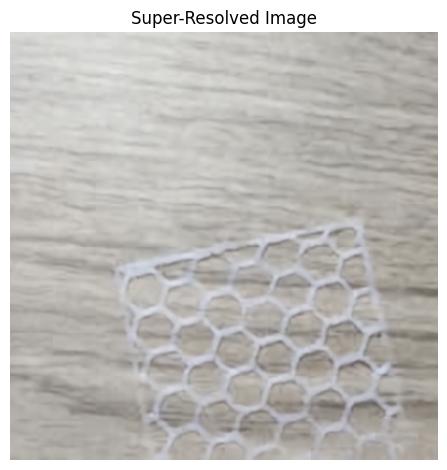

In [ ]:
sr_image = pretrained_model.super_resolve_image("low_z_offset.png", patch_size_lr=EDSR_PATCH_SIZE, stride=EDSR_STRIDE)

plt.imshow(sr_image)
plt.axis("off")
plt.title("Super-Resolved Image")
plt.tight_layout()
plt.show()